In [1]:
import numpy as np, matplotlib.pyplot as plt
%matplotlib inline

# Set font size for plotting
font = {'size':14}
plt.rc('font', **font)

# Import RomPy
import rompy as rp

In [2]:
integration = rp.Integration([0, 1000], num=10001, rule='trapezoidal')

In [3]:
integration.nodes

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 9.998e+02, 9.999e+02,
       1.000e+03])

In [4]:
integration.weights

array([0.05, 0.1 , 0.1 , ..., 0.1 , 0.1 , 0.05])

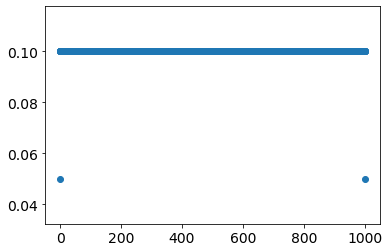

In [5]:
plt.figure()
plt.scatter(integration.nodes, integration.weights)

In [6]:
from pycbc import waveform

ModuleNotFoundError: No module named 'pycbc'

In [7]:
m2s = np.linspace(100, 50, 100)
hps = {}
for i, m2 in enumerate(m2s):
    hp, _ = waveform.get_fd_waveform(
        approximant="IMRPhenomHM",
        mass1=100,
        mass2=m2,
        delta_f=1/16,
        f_lower=30,
        distance=1e-19,
        inclination=np.pi/2
    )
    
    f = hp.sample_frequencies.numpy()[:]
    h = np.abs(hp.numpy()[:])
    
    mask = (f >= 30) & (f <= 150)
    f = f[mask]
    h = h[mask]

    data = {'f':f, 'h':h}
    hps.update({i:data})
    
training = np.array( [ hps[i]['h'] for i in range(len(hps)) ] )

x_start = f[0]
x_end = f[-1]
x_num = len(f)

NameError: name 'waveform' is not defined

In [8]:
training.shape

(100, 1921)

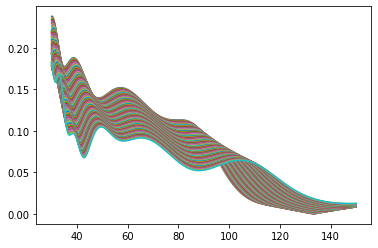

In [9]:
plt.figure()
for hp in hps.values():
    plt.plot(hp['f'], hp['h'])

In [10]:
integration = rp.Integration([x_start, x_end], num=x_num, rule='trapezoidal')

In [11]:
sur_L2 = rp.Surrogate(integration)

In [12]:
# Build the reduced-order model (i.e., reduced basis + empirical interpolant) 
# using the L2 loss function for computing projection errors
# sur_L2.MakeROM(training, 0, 1e-12)
sur_L2.MakeROM(training, 0, 1e-3)
print("Basis size =", sur_L2.rb.size)

# Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)
sur_L2.MakeFits(m2s, fit='spline', deg=5)

Basis size = 5


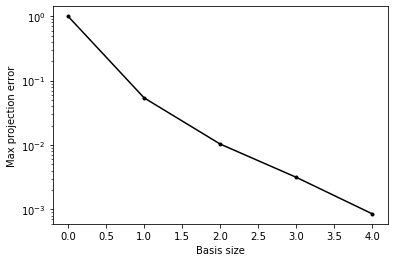

In [13]:
plt.semilogy(sur_L2.rb.errors/sur_L2.rb.errors[0], 'k.-');
plt.xlabel('Basis size')
plt.ylabel('Max projection error')
plt.show()

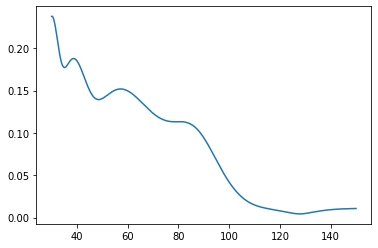

In [14]:
plt.figure()
plt.plot(integration.nodes, sur_L2.Eval(100))

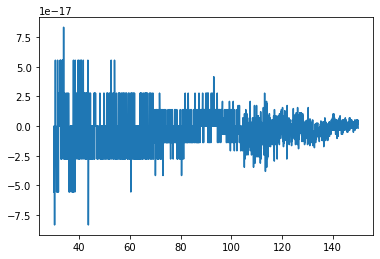

In [15]:
plt.figure()
plt.plot(integration.nodes, sur_L2.Eval(100) - hps[0]['h'])

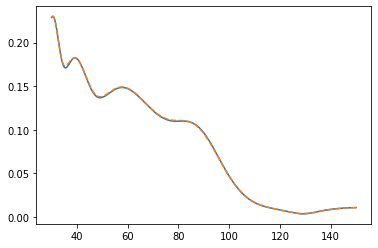

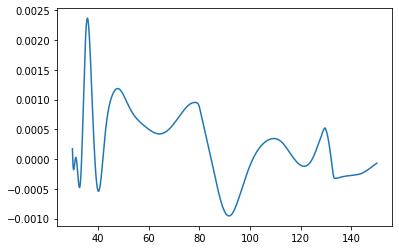

In [16]:

idx=5
plt.figure()
plt.plot(integration.nodes, hps[idx]['h'])
plt.plot(integration.nodes, sur_L2.Eval(m2s[idx]), ls='--')

plt.figure()
plt.plot(integration.nodes, sur_L2.Eval(m2s[idx]) - hps[idx]['h'])


In [17]:
%timeit sur_L2.Eval(100)

38.8 µs ± 1.03 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%%timeit
hp, _ = waveform.get_fd_waveform(
        approximant="IMRPhenomHM",
        mass1=100,
        mass2=100,
        delta_f=1/16,
        f_lower=30,
        distance=1e-19,
        inclination=np.pi/2.
)

20 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%%timeit
hp, _ = waveform.get_fd_waveform(
        approximant="IMRPhenomD",
        mass1=100,
        mass2=100,
        delta_f=1/16,
        f_lower=30,
        distance=1e-19,
        inclination=np.pi/2.
)

391 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# try 3d training

In [22]:
training = np.zeros((10,10,1921))

In [23]:
m2s = np.linspace(100, 50, 10)
s1zs = np.linspace(0, 1, 10)
hps = {}
for i, m2 in enumerate(m2s):
    hps = {}
    for j, s1z in enumerate(s1zs):
        hp, _ = waveform.get_fd_waveform(
            approximant="IMRPhenomHM",
            mass1=100,
            mass2=m2,
            spin1z=s1z,
            delta_f=1/16,
            f_lower=30,
            distance=1e-19,
            inclination=np.pi/2
        )

        f = hp.sample_frequencies.numpy()[:]
        h = np.abs(hp.numpy()[:])

        mask = (f >= 30) & (f <= 150)
        f = f[mask]
        h = h[mask]

        data = {'f':f, 'h':h}
        hps.update({i:data})
        
        training[i,j] = hps[i]['h']

#     training = np.array( [ hps[i]['h'] for i in range(len(hps)) ] )

x_start = f[0]
x_end = f[-1]
x_num = len(f)

In [26]:
sur_L2 = rp.Surrogate(integration)

In [38]:
# Build the reduced-order model (i.e., reduced basis + empirical interpolant) 
# using the L2 loss function for computing projection errors
sur_L2.MakeROM(training, 0, 1e-12)
# sur_L2.MakeROM(training, 0, 1e-3)
print("Basis size =", sur_L2.rb.size)

# Fit empirical node data to (default) 5th degree, non-smoothing splines (s=0)
# sur_L2.MakeFits(m2s, fit='spline', deg=5)

ValueError: shapes (1921,) and (10,1921) not aligned: 1921 (dim 0) != 10 (dim 0)